## **Problem Statement:**

> To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



>  The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.



> The data set contains the following diseases:
*   Actinic keratosis
*   Basal cell carcinoma
*   Dermatofibroma
*   Melanoma
*   Nevus
*   Pigmented benign keratosis
*   Seborrheic keratosis
*   Squamous cell carcinoma
*   Vascular lesion









Build a multiclass classification model using a custom convolutional neural network in TensorFlow.-

#### **Importing Important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D,MaxPool2D

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Data Understanding**

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Melanoma/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Melanoma/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Dataset Image Count:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Dataset Image Count:",image_count_test)

Train Dataset Image Count: 2239
Test Dataset Image Count: 118


In [4]:
#Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
#Setting random state to 42
tf.random.set_seed(42)  # Set a fixed random seed

Use 80% of the images for training, and 20% for validation.

In [6]:
## Loading training dataset
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Loading the validation data
## Using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Loading the testing data
# Using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# Resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Visualising the data**
#### Creating  code to visualize one instance of all the nine classes present in the dataset

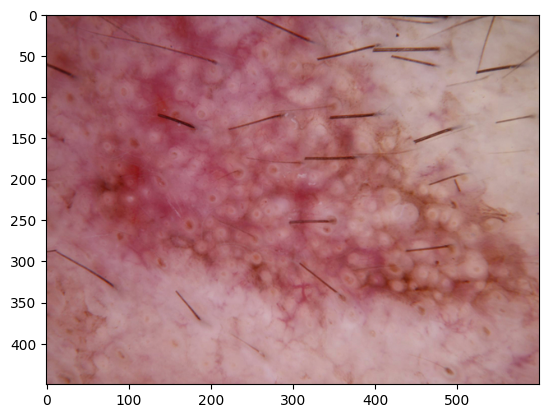

In [10]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

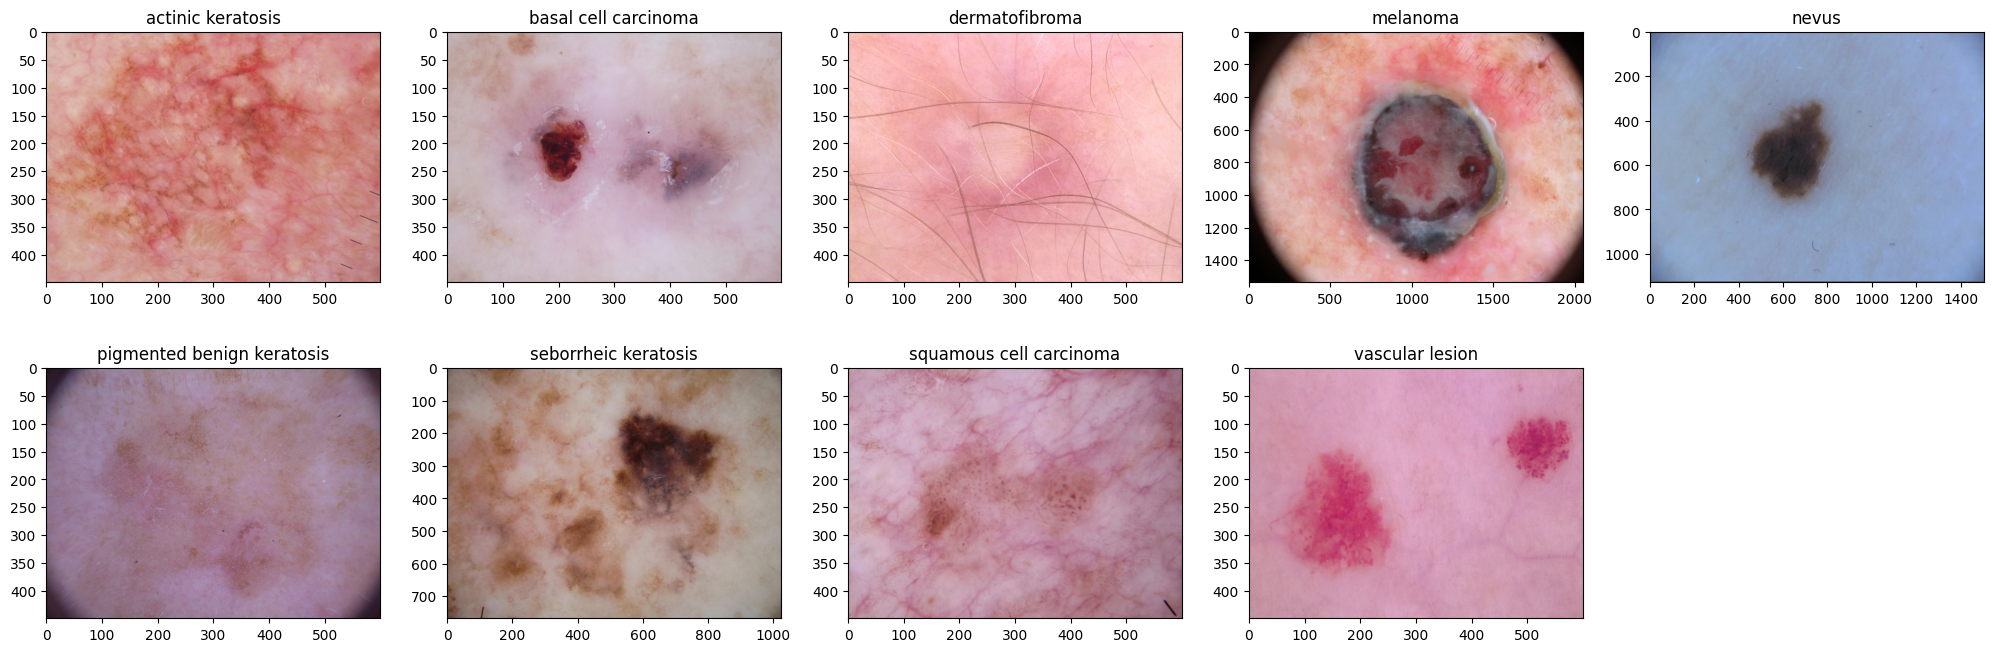

In [11]:
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
# Configure the dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

#### **Creating the model**
- Creating a CNN model, which can accurately detect 9 classes present in the dataset. The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`
-  While building the model, rescaling images to normalize pixel values between (0,1).
- Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.


In [14]:
#CNN Model
num_classes = 9
# scaling the pixel values from 0-255 to 0-1
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 64 features, 7x7 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 16 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 128 features, 11x11 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 128, kernel_size = (11,11),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 256 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(9, activation = "softmax"))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Training the model**

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 379s 1s/step - loss: 2.0507 - accuracy: 0.1875 - val_loss: 2.0286 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 2.0061 - accuracy: 0.2121 - val_loss: 1.9561 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9305 - accuracy: 0.2623 - val_loss: 1.8385 - val_accuracy: 0.2841
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7878 - accuracy: 0.3214 - val_loss: 1.8080 - val_accuracy: 0.3199
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7062 - accuracy: 0.3683 - val_loss: 1.5979 - val_accuracy: 0.3960
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.5418 - accuracy: 0.4542 - val_loss: 1.4705 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4689 - accuracy: 0.4844 - val_loss: 1.4703 - val_accuracy: 0.4787
Epoch 8/20
56

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        3

#### **Visualizing training results**

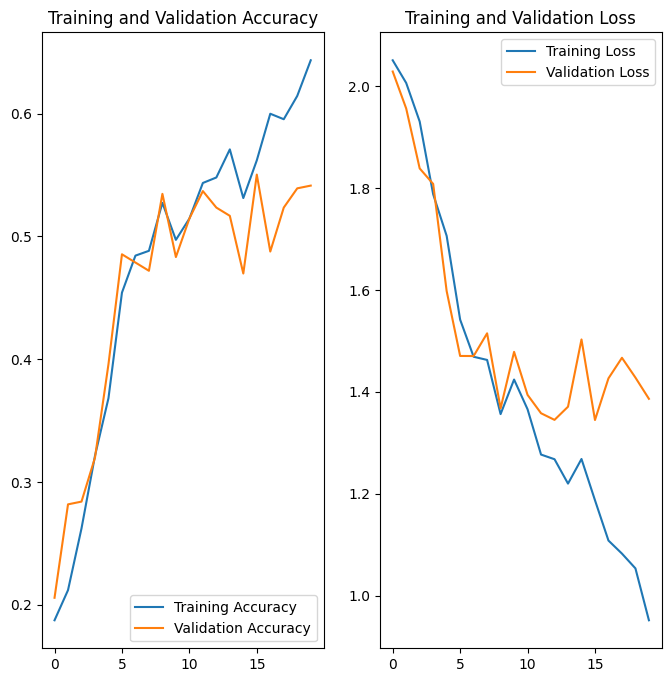

In [18]:
plot_cnn_metrics(history,epochs)

#### **Findings :**
- As the training accuracy **64%** increases linearly, the validation accuracy is at **54%** while training.
- As the training loss decreases with epochs the validation loss increases.
- The plots show that training accuracy and validation accuracy are off by large margins.
- The difference in accuracy between training and validation accuracy is **noticeable** which is a sign of overfitting.
- We could add some `Dropout` layers and remove the `BatchNormalization` layers.
-  And by adding a few more layers, we could improve the accuracy by trying to extract more features.


### **Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting**


- Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.



In [19]:
# Chosen augmentation strategy

data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

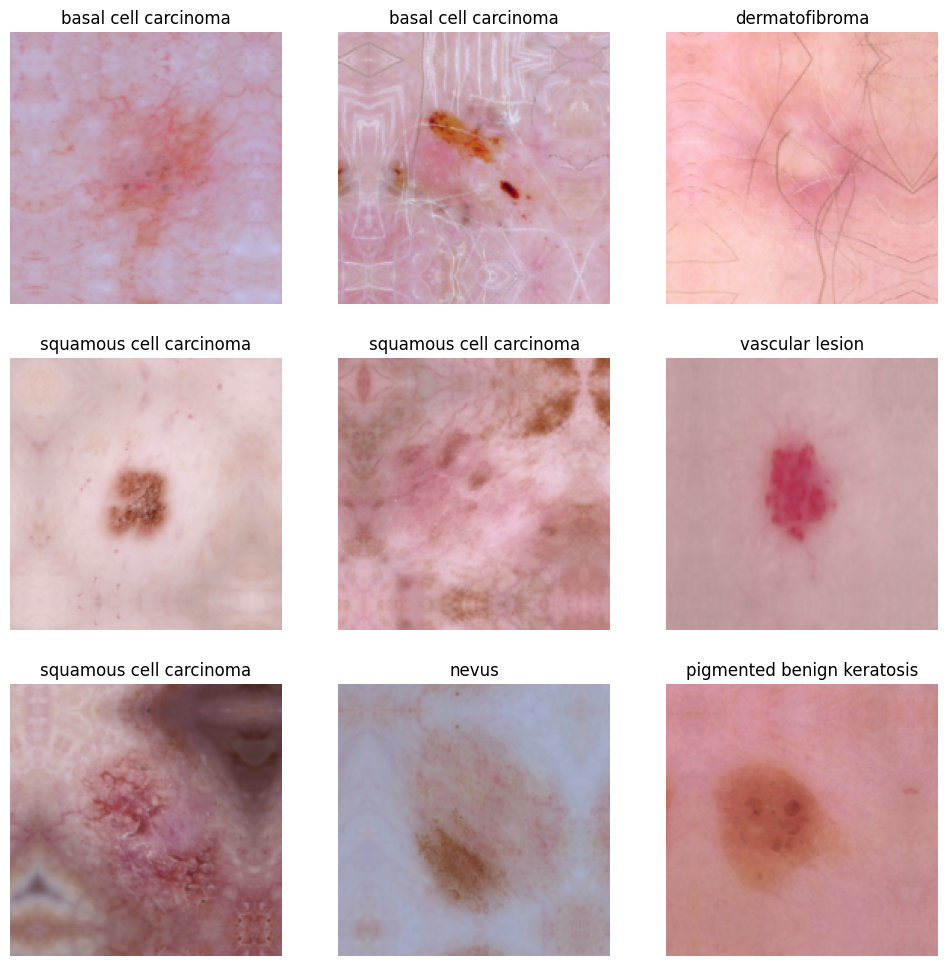

In [20]:
# visualizing how augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


## **Building Model and Training on Augmented Data with Dropout**

- Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
- Choosing an appropriate optimiser and loss function for model training
- Training the model for ~20 epochs
- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.


In [21]:
#CNN Model
num_classes = 9
# scaling the pixel values from 0-255 to 0-1
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 64 features, 7x7 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 64, kernel_size = (7,7),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 16 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 128 features, 11x11 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 128, kernel_size = (11,11),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 256 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(9, activation = "softmax"))

#### **Compiling the model**

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

#### **Training the model**

In [23]:
##  Training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 7s 64ms/step - loss: 2.0591 - accuracy: 0.1942 - val_loss: 2.0342 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 2.0010 - accuracy: 0.2031 - val_loss: 1.9071 - val_accuracy: 0.2998
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.8537 - accuracy: 0.2812 - val_loss: 1.9484 - val_accuracy: 0.2170
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 1.7794 - accuracy: 0.3449 - val_loss: 1.8769 - val_accuracy: 0.2953
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6920 - accuracy: 0.3516 - val_loss: 1.5961 - val_accuracy: 0.4049
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6403 - accuracy: 0.3984 - val_loss: 1.7549 - val_accuracy: 0.3960
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6266 - accuracy: 0.4007 - val_loss: 1.6106 - val_accuracy: 0.3848
Epoch 8/20
56

#### **Visualizing the results**

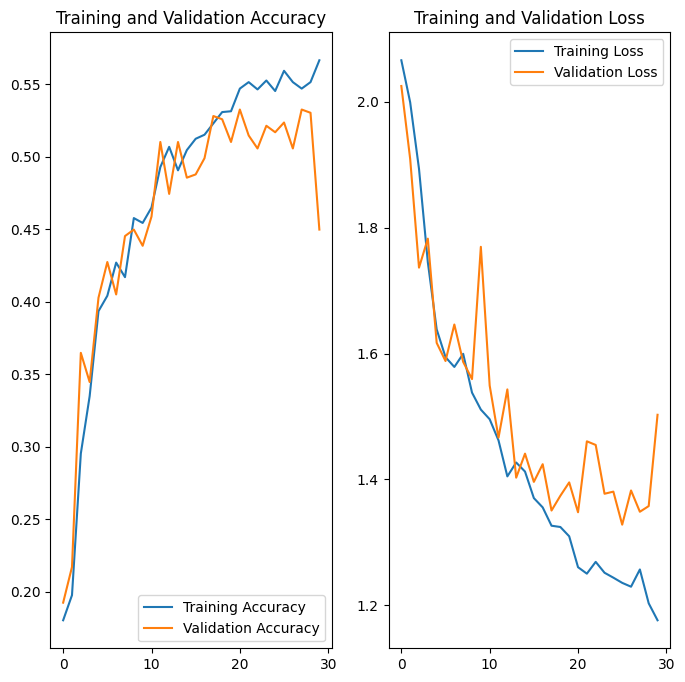

In [25]:
plot_cnn_metrics(history,epochs)


#### **Findings :**
- As the training accuracy **52%** increases linearly ,  the validation accuracy increases and is at **48%** accuracy in training process.
- As the training loss decreases with epochs the validation loss decreases.
- The plots show that gap between training accuracy and validation accuracy which have decreased from previous model.
- The difference in accuracy between training and validation accuracy is still **slightly noticeable** which is a sign of overfitting.

In [24]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion
2235,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion
2236,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion
2237,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion


##### **We can clearly see that the overfitting of the model has reduced significantly when compared the earlier models**


#### **Class Distribution**
- Examining the current class distribution in the training dataset

- Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

- Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

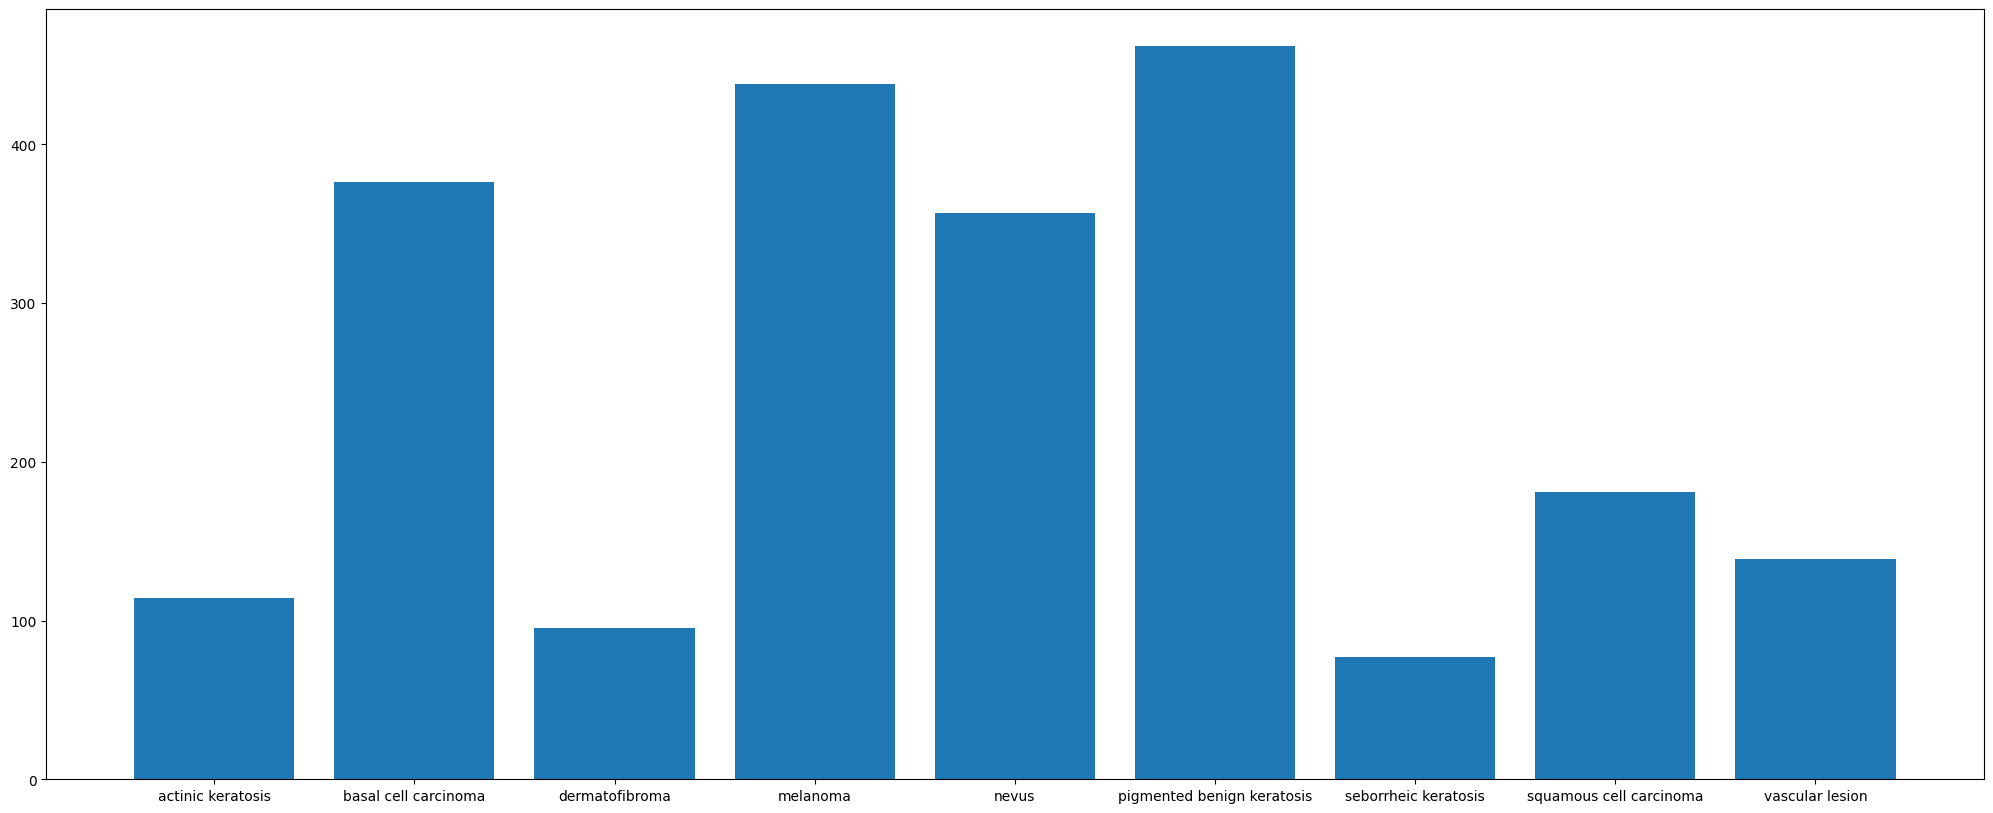

In [25]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [26]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


#### **Findings:**
#### - Which class has the least number of samples?
####      - **seborrheic keratosis  -  77**
#### - Which classes dominate the data in terms proportionate number of samples?
####      - **pigmented benign keratosis  -  462**


## **Handling Class Imbalances:**
Rectifing class imbalances present in the training dataset with Augmentor library.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F66741CC820>: 100%|██████████| 500/500 [00:17<00:00, 29.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F65F03F3CD0>: 100%|██████████| 500/500 [00:17<00:00, 29.34 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F66000BFF10>: 100%|██████████| 500/500 [00:18<00:00, 26.89 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F66000BF0A0>: 100%|██████████| 500/500 [01:31<00:00,  5.44 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2101x1943 at 0x7F6623F7CBB0>: 100%|██████████| 500/500 [01:29<00:00,  5.61 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F66000BC040>: 100%|██████████| 500/500 [00:16<00:00, 29.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6670713F10>: 100%|██████████| 500/500 [00:39<00:00, 12.75 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F667044F400>: 100%|██████████| 500/500 [00:17<00:00, 28.41 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Melanoma/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F66000BD870>: 100%|██████████| 500/500 [00:17<00:00, 28.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### **Lets see the distribution of augmented data after adding new images to the original training data.**

In [30]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

['/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output/nevus_original_ISIC_0027958.jpg_2c30b306-7900-4c3b-96fc-73c918eb4973.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output/nevus_original_ISIC_0000320.jpg_b3ba3fb2-1b1c-49f7-9cc4-cafe453a9203.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output/nevus_original_ISIC_0000343.jpg_35376e13-4f71-475d-bd2f-ffb8ad4f89c6.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output/nevus_original_ISIC_0000328.jpg_96b63ba1-7458-46e5-9d9c-1751e35e4ac2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output/nevus_original_ISIC_0024468.jpg_95c63c15-ee5a-4961-ae67-19aca6706b64.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output/nevus_original_ISIC_0000468.jpg_63fa5b5f-5a8f-4f2c-b052-fa698d478af1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/nevus/output/nevus_original_ISIC_0010889.jpg_15619d67-437e-41d7-94a8-c7f3d498eea

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
for i in class_names:
    directory ='/content/drive/MyDrive/Colab Notebooks/Melanoma/Train'
    directory_out ='/content/drive/MyDrive/Colab Notebooks/Melanoma/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} : {length_tot}')

actinic keratosis : 614
basal cell carcinoma : 876
dermatofibroma : 595
melanoma : 938
nevus : 857
pigmented benign keratosis : 962
seborrheic keratosis : 577
squamous cell carcinoma : 681
vascular lesion : 639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [34]:
data_dir_train1 = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Melanoma/Train/output")

In [35]:
for i in class_names:

    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)

dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
1,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
2,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
3,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
4,/content/drive/MyDrive/Colab Notebooks/Melanom...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion
2235,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion
2236,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion
2237,/content/drive/MyDrive/Colab Notebooks/Melanom...,vascular lesion


####  **Training the model on the data created using Augmentor**

In [36]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

#### **Creating a training dataset**

In [37]:
data_dir_train

PosixPath('/content/drive/MyDrive/Colab Notebooks/Melanoma/Train')

In [38]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Creating a validation dataset**

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Building Model & training on the rectified class imbalance data :**
- Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
- Choosing an appropriate optimiser and loss function for model training
- Training the model for ~30 epochs
- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.


In [40]:
# CNN Model
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
# Convolution layer with 32 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer with 256 features, 11x11 filter and relu activation with 2x2 pooling
model.add(Conv2D(filters = 256, kernel_size = (11,11),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(9, activation = "softmax"))

#### **Compiling the model**

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 128)      

#### **Training the model**

In [42]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 218ms/step - loss: 2.0871 - accuracy: 0.1766 - val_loss: 2.0519 - val_accuracy: 0.2405
Epoch 2/30
169/169 [==============================] - 39s 226ms/step - loss: 1.7254 - accuracy: 0.3314 - val_loss: 1.6457 - val_accuracy: 0.3734
Epoch 3/30
169/169 [==============================] - 39s 227ms/step - loss: 1.5088 - accuracy: 0.4165 - val_loss: 1.4397 - val_accuracy: 0.4454
Epoch 4/30
169/169 [==============================] - 35s 203ms/step - loss: 1.4156 - accuracy: 0.4392 - val_loss: 1.4182 - val_accuracy: 0.4432
Epoch 5/30
169/169 [==============================] - 35s 199ms/step - loss: 1.3022 - accuracy: 0.4941 - val_loss: 1.3520 - val_accuracy: 0.4692
Epoch 6/30
169/169 [==============================] - 36s 206ms/step - loss: 1.2261 - accuracy: 0.5254 - val_loss: 1.2325 - val_accuracy: 0.5048
Epoch 7/30
169/169 [==============================] - 37s 210ms/step - loss: 1.1389 - accuracy: 0.5671 - val_loss: 1.1449 - val_ac

#### **Visualising the model results**

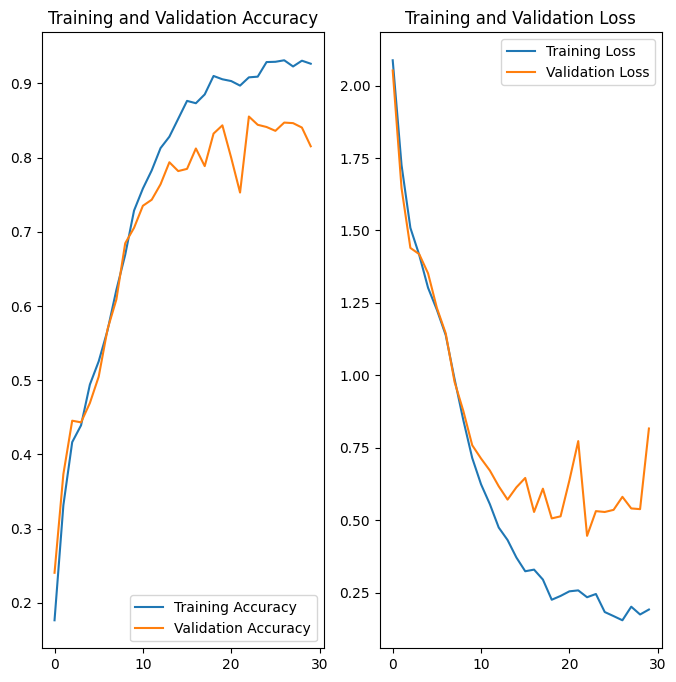

In [43]:
plot_cnn_metrics(history,epochs)

#### **Findings :**
- As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
- As the training loss decreases with epochs the validation loss also decreases.
- The plots show that  training accuracy **92%** and validation accuracy around **81%** .
- The difference in accuracy between training and validation accuracy is very less
- Class rebalancing not only reduced overfitting, it also improved the accuracy from **48%** to **81%**.